# Total Offense Score

The goal of this article is to create a new metric to judge a single player's offensive production. I know there is a ton out there already (PER, OWS, OBPM, etc.) but I wanted to try my hand at creating one and possibly find ways improve upon them. My metric will mostly be based on total production and how efficient that player was at achieving that production.

### Method

I measured total production as points generated ($PGEN$), which is the sum of the points the player generated either through scoring or passing, for which we will include second assists and free throw assists. The formula is as follows:

$$PGEN = PTS + \frac{AST\:PTS\:CREATED}{AST + FT\:AST} * (AST + 2nd\:AST + FT\:AST)$$

We are getting our stats from nba.com/stats, which includes $FT\:AST$ in their calculation for AST\:PTS\:CREATED but does not include 2nd\:AST so we find the player's points per assist and multiply that by the total of the three types to estimate the total points generated through passing.

To measure efficiency I will be using a stat called Individual Offensive Efficiency with Assist Opportunities ($IOEwAO$) which is $PGEN$ divided by the number or possessions that player terminated ($NPTwAO$) either by shooting, making a pass that leads to a shot, or turning the ball over. I know those are complicated abbreviations but $IOEwAO$ can differ from just Individual Offensive Efficiency which doesn't take into account potential assists. I will be using assist opportunities as it is more indicative of how often that player ends a possession.

$$NPTwAO = FGA + .44*FTA + TOV + ASSIST\:OPORTUNITIES + 2nd\:AST - OREB$$

$$IOEwAO = \frac{PGEN}{NPTwAO}$$

You may notice that I included offensive rebounds in the $NPTwAO$ calculation, this is because NPT stands for net possessions terminated and offensive rebound earns the team another possession. Also, $FT\:AST$ was not included because on on nba.com/stats $ASSIST\:OPORTUNITIES$ and $FT\:AST$ overlap.

We multiply free throws by 0.44 since not every time does a player shoot two free throws for a foul. 0.44 gives us a better estimate of the actual number of possessions.

Ok so this is the bulk of the information that will be used, now I have to get the data. Using the nba_api repository on github, I wrote a Python Script to scrape the necessary data for every active player in the 2019-20 NBA season into a spreadsheet, and calculated their $PGEN$, $NPTwAO$, and $IOEwAO$ along with some other metrics that this article will not focus on. 

In [39]:
import pandas as pd

df = pd.read_csv('offensive_efficiency_19_20.csv')
df[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS', 'FGA', 'FTA', 
    'TOV', 'OREB', 'PGen', 'NPTwAO', 'PGen/G', 'NPTwAO/G', 'IOEwAO']].head(10)

,PLAYER_NAME,TEAM_ABBREVIATION,GP,PTS,FGA,FTA,TOV,OREB,PGen,NPTwAO,PGen/G,NPTwAO/G,IOEwAO
0,Aaron Gordon,ORL,62,894,767,224,100,107,1501.200000,1296.56,24.212903,21.27,1.157833
1,Aaron Holiday,IND,66,627,563,87,88,22,1287.780876,1133.28,19.511831,17.56,1.136331
2,Abdel Nader,OKC,55,345,263,66,43,14,449.268293,391.04,8.168514,7.16,1.148906
3,Adam Mokoka,CHI,11,32,28,4,2,7,44.500000,33.76,4.045455,3.07,1.318128
4,Admiral Schofield,WAS,33,99,92,15,7,7,143.705882,128.60,4.354724,3.96,1.117464
5,Al Horford,PHI,67,798,709,80,80,103,1512.297945,1156.20,22.571611,17.59,1.307990
6,Al-Farouq Aminu,ORL,18,78,86,29,17,24,137.400000,140.76,7.633333,8.04,0.976130
7,Alec Burks,PHI,66,993,768,265,91,48,1522.879808,1302.60,23.073936,20.02,1.169108
8,Alen Smailagic,GSW,14,59,40,19,11,10,93.000000,66.36,6.642857,4.74,1.401447
9,Alex Caruso,LAL,64,349,291,94,53,17,679.244604,603.36,10.613197,9.66,1.125770


The full spreadsheet contains 41 columns. If you are interested in checking it out, it can be found here, but the above columns are what we are going to use in ths article.

First let's find the league average in points per posession. This can be closely estimated by dividing the total points by the total possesions, using the .44 weight for free throws mentioned before. 

$$PPP = \frac{PTS}{FGA + .44*FTA + TOV - OREB}$$

In [40]:
ppp = df['PTS'].sum() / (df['FGA'].sum() + .44*df['FTA'].sum() + df['TOV'].sum() - df['OREB'].sum())
print(ppp)

1.0873277667011825


So roughly 1.09 points are scored per possession in the NBA. Having an $IOEwAO$ above this would mean the player produces points at an above average rate, which is good, and should be rewarded in our metric. A below average rate should be punished. To accomplish this, I will take the players $PGEN/G$ and raise it to the power of their $IOEwAO$ divided by $PPP$ which we will call the efficiency factor.

$$PGEN/G^{\frac{IOEwAO}{PPP}}$$

This makes it so a player's $PGEN/G$ value increases at an exponential rate if it was done on good efficiency, and decreases at an exponential rate on poor efficiency.
For example:

In [29]:
print('PGen = 30, IOEwAO = 1, Score =', 30**(1/1.087))
print('PGen = 30, IOEwAO = 1.2, Score =', 30**(1.2/1.087))

PGen = 30, IOEwAO = 1, Score = 22.85057844894064
PGen = 30, IOEwAO = 1.2, Score = 42.724465491574115


Using this, lets see how players stack up against each other. Note that this is a average per game metric which differs from some like OWS and OPBM.

In [30]:
df['Score'] = df['PGen/G'] ** (df['IOEwAO'] / ppp)
df[['PLAYER_NAME', 'NPTwAO/G', 'PGen/G', 'IOEwAO', 'Score']].sort_values('Score', ascending = False).head(25)

,PLAYER_NAME,NPTwAO/G,PGen/G,IOEwAO,Score
90,Damian Lillard,42.07,52.270929,1.261881,98.650533
364,Mitchell Robinson,5.51,11.190416,2.049158,94.762398
215,James Harden,47.50,56.209223,1.200825,85.596552
383,Nikola Jokic,29.51,38.220744,1.324564,84.630986
424,Rudy Gobert,12.11,19.491754,1.621689,83.896069
312,Kyrie Irving,37.89,46.461379,1.254221,83.747851
221,Jarrett Allen,9.21,15.802198,1.734327,81.657820
325,Luka Doncic,45.48,53.628274,1.196849,80.091785
281,Karl-Anthony Towns,29.36,37.659113,1.309635,79.078980
319,LeBron James,44.95,52.825918,1.196271,78.607847


This is the top 25 players ranked by our new score.

Our current formula would tell us that last year, Mitchell Robinson was one of the most productive offensive players in the league. It's understandable if you don't believe this, but he did have a superb IOEwAO at 2.005, much better than the rest of the top 25. However, if you notice, he only had about 5.5 possessions terminated a game so it was much easier to reach his high efficiency compared to the number 1 player, Damian Lillard, who had 42 possessions terminated per game.

This is a flaw that we need to account for. To do this I will introduce another equation and variable called possession weight.

$$POS\:WT = 1 - 10^{-(\frac{NPTwAO/G}{Average\:NPTwAO/G})}$$

Now this is a little complicated so I will do my best to explain. Basically possession weight will come out with a value in between 0 and 1. The larger the player's $NPTwAO/G$, the closer to 1 and visa versa. The score from above will be multiplied by this weight. Below is a plot of the weights by $NPTwAO/G$.

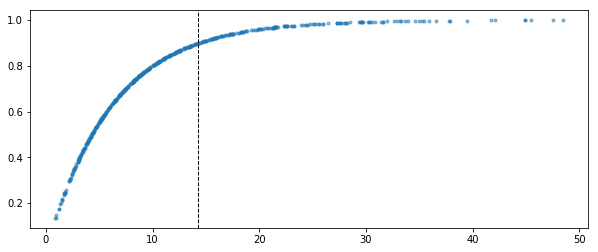

In [31]:
import matplotlib.pyplot as plt

npt_avg = df['NPTwAO'].sum() / df['GP'].sum()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(df['NPTwAO/G'], (1 - 10 ** (-1*df['NPTwAO/G'] / npt_avg)), '.', alpha=.5)
plt.axvline(14.3, color='k', linestyle='dashed', linewidth=1)
# print(df['NPTwAO/G'].mean())
plt.show()

If the player's $NPTwAO/G$ is equal to the league average, the weight comes out to 0.90, which is the dotted vertical line. High above the average and the score will barely change as the weight get closer to 1, way below and it is affected significantly.

### Results

Now let's look at our new updated rankings.

In [42]:
df['Eff_Factor'] = (df['IOEwAO'] / ppp)
df['Pos_Weight'] =  (1 - 5 ** (-1*df['NPTwAO/G'] / npt_avg))
df['Score'] = df['PGen/G'] ** df['Eff_Factor'] * df['Pos_Weight']


df[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'NPTwAO/G', 'PGen/G', 'IOEwAO', 'Eff_Factor', 'Pos_Weight', 'Score']].to_csv('player_score_results.csv')

df[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'NPTwAO/G', 'PGen/G', 'IOEwAO', 'Eff_Factor', 'Pos_Weight', 'Score']].sort_values('Score', ascending = False).head(25)

,PLAYER_NAME,TEAM_ABBREVIATION,NPTwAO/G,PGen/G,IOEwAO,Eff_Factor,Pos_Weight,Score
90,Damian Lillard,POR,42.07,52.270929,1.261881,1.160534,0.991203,97.782672
215,James Harden,HOU,47.50,56.209223,1.200825,1.104382,0.995224,85.187778
312,Kyrie Irving,BKN,37.89,46.461379,1.254221,1.153490,0.985920,82.568697
383,Nikola Jokic,DEN,29.51,38.220744,1.324564,1.218183,0.963854,81.571881
325,Luka Doncic,DAL,45.48,53.628274,1.196849,1.100726,0.994006,79.611701
319,LeBron James,LAL,44.95,52.825918,1.196271,1.100194,0.993638,78.107706
281,Karl-Anthony Towns,MIN,29.36,37.659113,1.309635,1.204453,0.963238,76.171910
175,Giannis Antetokounmpo,MIL,37.82,45.957049,1.225386,1.126971,0.985809,73.657125
474,Trae Young,ATL,48.45,55.033549,1.158617,1.065564,0.995709,71.265972
133,Domantas Sabonis,IND,24.42,31.984065,1.329774,1.222974,0.935912,64.823166


Based on our new offensive score metric, these were the top 25 offensive players of the 2019-20 season. Note that a few of these players, like Steph Curry and Kyrie Irving missed a lot of games but had hish scores the games they did play. Outside of that, I would say this is a pretty reasonable list, to make it to the top you need both volume and efficiency. I also believe playmaking is better rated in this metric than others by including assist opportunities, 2nd assists, and free throw assists.

What I like most about this metric is that volume at the cost of efficiency will hurt your score. For example, lets take an estimated Damian Lillard game where he has 42 NPTwAO and 52 PGen. Now let's say he continues to take 5 more shots, and makes 2 of them shooting 40% for 4 points, only producing .8 ppp. He would now have 47 NPTwAO and 56 PGen. Let's look at the difference in final scores between the two instances of the game.

In [35]:
score = 52 ** ((52/42)/ppp) * (1 - 5 ** (-1*42 / npt_avg))
print('Score before shots', score)
score_final = 56 ** ((56/47)/ppp) * (1 - 5 ** (-1*47 / npt_avg))
print('Score after shots', score_final)

Score before shots 89.14031151364419
Score after shots 81.93279421061916


One flaw I have with PER, whose formula can be found here, is that a player can improve their score with volume as long as they are shooting above 30.4% from the field. If I had a player shooting around 35%, I would not want him to increase his volume. My metric makes it so increasing volume is curved by the efficiency factor heavily so that volume is only good when they are producing above league average efficiency.

### Flaws

Now I will admit there are some flaws to this metric. Being a purely offensive stat focused metric, it leaves out stats like defensive rebounds, blocks, and steals which could lead to offensive possessions and may unfairly omit a good defender's actual contribution. It doesn't adjust for pace so plyers on teams that play faster might get more opportunities to generate points leading to higher scores. Using assist opportunities puts reliance on teammates to make shots, so a player's playmaking score might be a lot lower on a bad team than it would a good team, as you probably noticed there are only a few instances of a player on a bad team. I didn't really know how to go about this because leaving out unconverted opportunities misconstrues that player's usage, but if I were to try and regularize the conversion of assist opportunities it may unfairly punish those who set up their teammates better which is why their team is better in the first place.

This isn't really a flaw in the stat but another issue is that 2nd assists, free throw assists, and assist opportunities only go back to the 13-14 season when player tracking started so we will be unable to compare offensive scores historically unfortunately, unless we figure out a way to estimate these stats.

### Conclusion

I feel this is a good metric to compare offensive performances. This is not to show how skilled a player is necessarily as a lot of it is based on opportunity, but all the time we spend on comparing performance, I think this metric does a better job than most when it comes to offense. It can be used for single game matchups as well as whole seasons differentiating itself to metrics like offensive win shares, and in my opinion pretty unbiased to position.

While there are some flaws and can get a bit complicated, I believe this is a simpler metric to understand than other popular ones that get even more complicated, as it can be boiled down to pretty much volume affected by efficiency. A future task would be to figure out how to incorporate defense which can be extremely hard to measure in numbers.